# Seurat: Xenium
conda env: single-cell_R-4.0.3

In [1]:
library(Seurat)
library(future)
library(dplyr)
library(scales) # color palette: hue_pal()
library(ggplot2)
library(tibble)
library(ggrepel)

# Specific requirement for xenium: 
library(arrow) # -> Helps to read in .parquet file

set.seed(49)

# Function for setting the size of figures in the notebook
figsize <- function(width, height) {
    options(repr.plot.width = width, repr.plot.height = height)
}

Warning message:
“package ‘Seurat’ was built under R version 4.0.5”


Warning message:
“replacing previous import ‘spatstat.utils::RelevantNA’ by ‘spatstat.sparse::RelevantNA’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::grokIndexVector’ by ‘spatstat.sparse::grokIndexVector’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::fullIndexSequence’ by ‘spatstat.sparse::fullIndexSequence’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::positiveIndex’ by ‘spatstat.sparse::positiveIndex’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::replacementIndex’ by ‘spatstat.sparse::replacementIndex’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::RelevantEmpty’ by ‘spatstat.sparse::RelevantEmpty’ when loading ‘spatstat.core’”
Warning message:
“replacing previous import ‘spatstat.utils::isRelevantZero’ by ‘spatstat.sparse::isRelevantZero’ when loading ‘spatstat

In [2]:
dir = "/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/spatial_datasets/Xenium5k_NSCLC/202503_Francesca"

In [3]:
# PanCancer scRNA-seq reference data
pancancer_sc <- readRDS("/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/PanCancer/DC3_noLQ_fUMAP_08-03-2024.rds")
pancancer_sc$annot_DC3 <- factor(pancancer_sc$annot_DC3, levels = c("cDC1", "cDC2", "AXL_DC", "DC3", "Lang-likeDC", "pDC", "mQuiescDC", "mRegDC"))

# # Create spatial object (V5->V4)
obj_v5 <- readRDS(paste0(dir, "/xenium5k_obj_DC.rds"))
obj <- CreateSeuratObject(counts = obj_v5[['Xenium']]@counts, meta.data = obj_v5@meta.data, assay = "Xenium")

[1] "Summary of uniqueRNA"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  101.0   170.5   246.0   281.6   353.0  1197.0 
[1] "Summary of counts"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  110.0   206.0   310.0   382.9   480.0  2659.0 


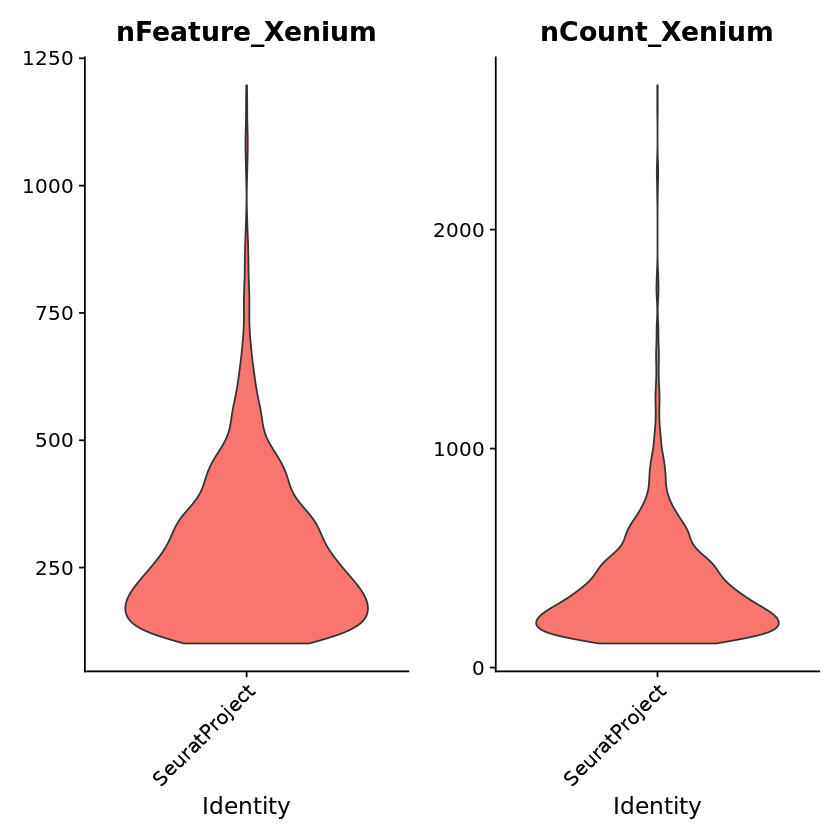

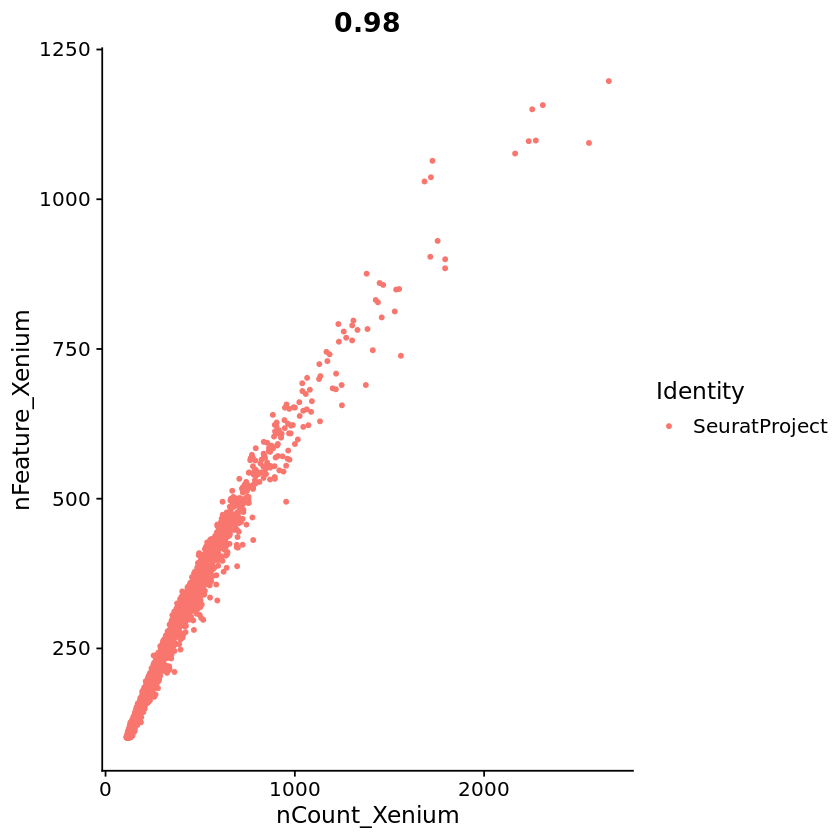

In [4]:
print("Summary of uniqueRNA")
print(summary(obj$nFeature_Xenium))
print("Summary of counts")
print(summary(obj$nCount_Xenium))

Idents(obj) <- "SeuratProject"
VlnPlot(obj, features = c("nFeature_Xenium", "nCount_Xenium"), ncol = 2, pt.size = 0)
FeatureScatter(obj, feature1 = "nCount_Xenium", feature2 = "nFeature_Xenium") 

In [5]:
# Clean everything in case we did the PCA analysis before
obj <- DietSeurat(obj)

# Normalize data and calculate cell cycle scores
obj <- NormalizeData(obj, normalization.method = "LogNormalize", scale.factor = 10000)
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
obj <- CellCycleScoring(obj, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

Warning message:
“The following features are not present in the object: GINS2, CDCA7, DTL, PRIM1, MLF1IP, RFC2, NASP, RAD51AP1, GMNN, WDR76, SLBP, CCNE2, UBR7, POLD3, ATAD2, CDC45, TIPIN, DSCC1, USP1, CLSPN, POLA1, CHAF1B, E2F8, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: NDC80, NUF2, CKS1B, TACC3, FAM64A, CKAP2L, TUBB4B, GTSE1, KIF20B, HJURP, HN1, NCAPD2, DLGAP5, CDCA8, ECT2, KIF23, ANLN, LBR, CENPE, G2E3, GAS2L3, not searching for symbol synonyms”


In [6]:
# Perform cluster analysis
obj <- FindVariableFeatures(obj, nfeatures = 2000) %>%
        ScaleData(do.scale=TRUE, vars.to.regress = c("S.Score", "G2M.Score")) %>%
        RunPCA(npcs=30) %>%
        RunUMAP(dims = 1:30, min.dist=0.05) %>%
        FindNeighbors(reduction = "pca", dims = 1:30) %>%
        FindClusters(resolution = c(0.1, 0.2, 0.3, 0.5, 0.8))

Regressing out S.Score, G2M.Score

Centering and scaling data matrix

PC_ 1 
Positive:  EPCAM, CDH1, DDR1, FCGBP, CTNND1, CLDN1, DNAH9, LAPTM4B, DHCR24, IGFBP2 
	   SCNN1A, CD1A, CLPTM1L, CD207, CP, NKX2-1, CFAP43, ERBB3, FOLR1, TPPP3 
	   HHLA2, AXL, TEKT1, ST14, TMPRSS2, MACC1, MUC5B, PARM1, FOXJ1, CTTN 
Negative:  CCL19, CXCR4, FSCN1, LAMP3, LY75, CD44, DUSP5, CCL22, CD200, KIF2A 
	   CD3E, CDKN1A, CCR7, TRAF1, RFTN1, CD83, CD274, EBI3, IRF1, TNFRSF11A 
	   ETV3, CCR4, SYNPO2, LAD1, FOXO1, IRF4, IL15, TFPI2, IDO1, ETS1 
PC_ 2 
Positive:  DNAH9, CFAP43, TEKT1, GZMB, SPATA18, PROM1, DNAH11, SPAG6, ALOX15, TPPP3 
	   DRC3, DRC1, DLEC1, MUC5B, MAPK15, CFAP46, SLC22A4, IGFBP2, FOXJ1, ZMYND10 
	   SPAG17, IL3RA, LILRA4, ERN1, EFHC2, ECRG4, CCDC113, CELSR1, DNAH2, DERL3 
Negative:  SGK1, FCGR2A, ITGAX, CLEC5A, AXL, CLEC10A, FCGR2B, PLAUR, ALOX5, CSF1R 
	   SLC2A3, HSPA6, HIF1A, CLEC7A, METRNL, ABI3, VEGFA, CLEC4A, HBEGF, MRC1 
	   OLR1, CIITA, ENTPD1, VASP, CPVL, NLRP3, F13A1, FCER1A, AOAH

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2227
Number of edges: 101370

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9288
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2227
Number of edges: 101370

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8913
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2227
Number of edges: 101370

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8637
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2227
Number of edges: 101370

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8278
Number of communities: 8
Elapsed time: 0 seconds
Modularity Optimizer

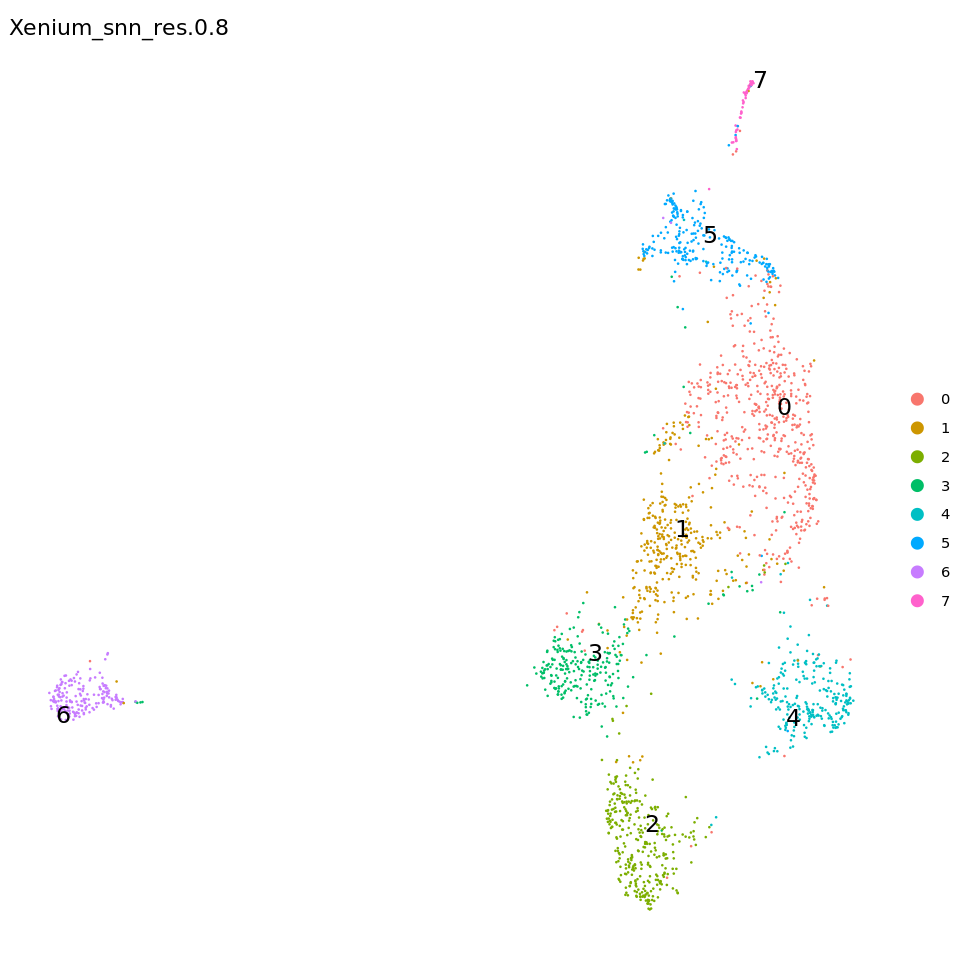

In [7]:
figsize(8, 8)
DimPlot(obj, group.by = "Xenium_snn_res.0.8", raster=FALSE, label=TRUE, label.size=5, pt.size = 0.1, repel = TRUE) + theme_void()# + NoLegend()

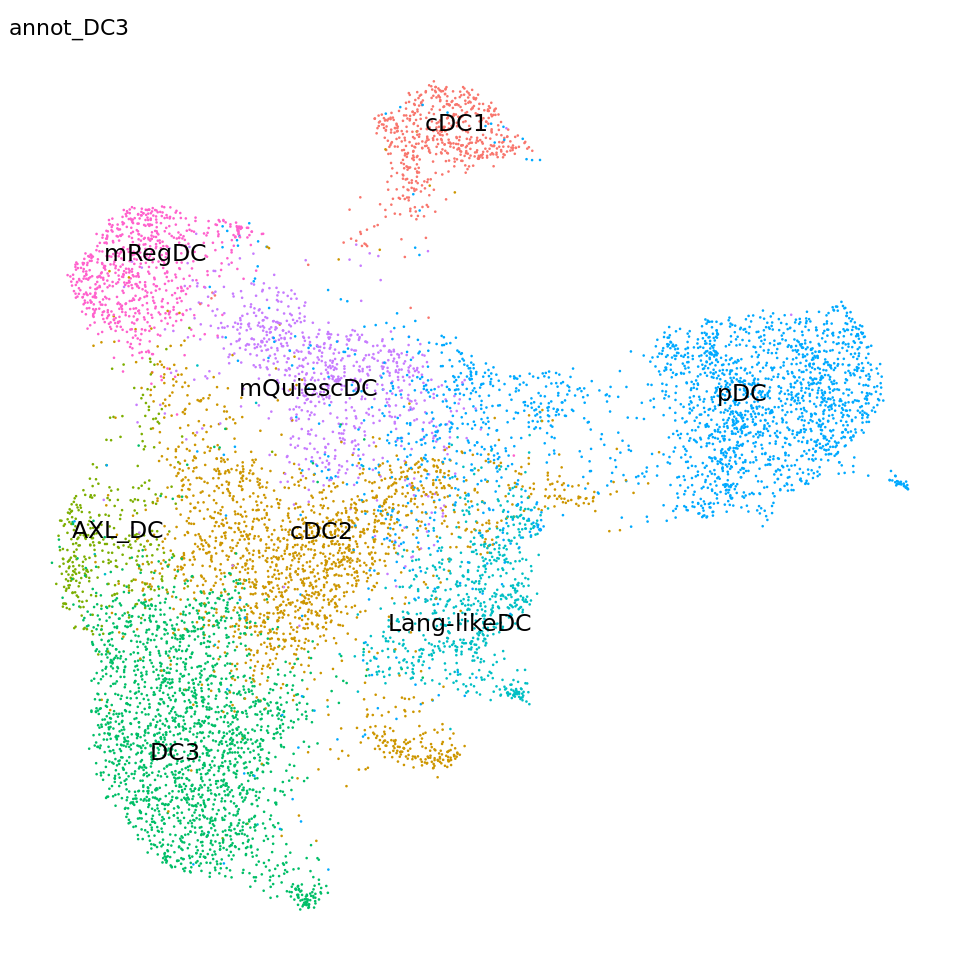

In [8]:
# Subtype annotation in reference dataset (PanCancer atlas)
figsize(8, 8)
DimPlot(pancancer_sc, group.by = "annot_DC3", raster=FALSE, label=TRUE, label.size=5, pt.size = 0.1, repel = TRUE) + theme_void()+ NoLegend()

## Seurat Integration

In [9]:
# Clean the spatial data
DefaultAssay(obj) <- "Xenium"
obj$Batch <- "Xenium"
pancancer_sc$Batch <- "Single-cell"

In [10]:
# Get the common genes between the two datasets
common_genes <- rownames(obj)[rownames(obj) %in% rownames(pancancer_sc)]
pancancer_sc <- pancancer_sc[common_genes, ]

In [11]:
# Create query subset
obj.query <- obj
obj.query <- obj.query[common_genes, ]

# Create reference dataset
obj.ref <- pancancer_sc
obj.ref <- RunPCA(obj.ref, npcs=30, verbose = F)
obj.ref$annot_DC3 <- factor(obj.ref$annot_DC3)

In [12]:
obj.ref
obj.query

An object of class Seurat 
5001 features across 9460 samples within 1 assay 
Active assay: RNA (5001 features, 693 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

An object of class Seurat 
5001 features across 2227 samples within 1 assay 
Active assay: Xenium (5001 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [13]:
options(future.globals.maxSize= 6000*1024^2)

obj.query <- NormalizeData(obj.query)
obj.anchors <- FindTransferAnchors(reference = obj.ref,
                                        query = obj.query,
                                        dims = 1:30,
                                        reference.reduction = "pca")

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 4669 anchors

Filtering anchors

	Retained 2836 anchors



In [14]:
predictions <- TransferData(anchorset = obj.anchors, refdata = obj.ref$annot_DC3, dims = 1:30)
obj.query <- AddMetaData(obj.query, metadata = predictions)

Finding integration vectors



Finding integration vector weights

Predicting cell labels



In [15]:
options(scipen = 999)
round(100*prop.table(table(obj.query$predicted.id)), 2)
round(100*prop.table(table(obj.ref$annot_DC3)), 2)


     AXL_DC        cDC1        cDC2         DC3 Lang-likeDC   mQuiescDC 
       1.21       10.46       24.29       18.59        8.22        4.09 
     mRegDC         pDC 
      19.04       14.10 


       cDC1        cDC2      AXL_DC         DC3 Lang-likeDC         pDC 
       5.90       20.70        3.69       22.01        7.41       24.41 
  mQuiescDC      mRegDC 
       8.46        7.43 

In [16]:
obj.ref <- RunUMAP(obj.ref, dims = 1:30, reduction = "pca", return.model = TRUE)
obj.query <- MapQuery(anchorset = obj.anchors, reference = obj.ref, query = obj.query,
    refdata = list(celltype = "annot_DC3"), reference.reduction = "pca", reduction.model = "umap")

UMAP will return its model

16:49:36 UMAP embedding parameters a = 0.9922 b = 1.112

16:49:36 Read 9460 rows and found 30 numeric columns

16:49:36 Using Annoy for neighbor search, n_neighbors = 30

16:49:36 Building Annoy index with metric = cosine, n_trees = 50



0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:49:37 Writing NN index file to temp file /tmp/RtmpeAg6FO/file2bd9ecb56be05

16:49:37 Searching Annoy index using 1 thread, search_k = 3000

16:49:40 Annoy recall = 99.9%

16:49:41 Commencing smooth kNN distance calibration using 1 thread

16:49:41 Initializing from normalized Laplacian + noise

16:49:41 Commencing optimization for 500 epochs, with 423452 positive edges

16:49:57 Optimization finished

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting ke

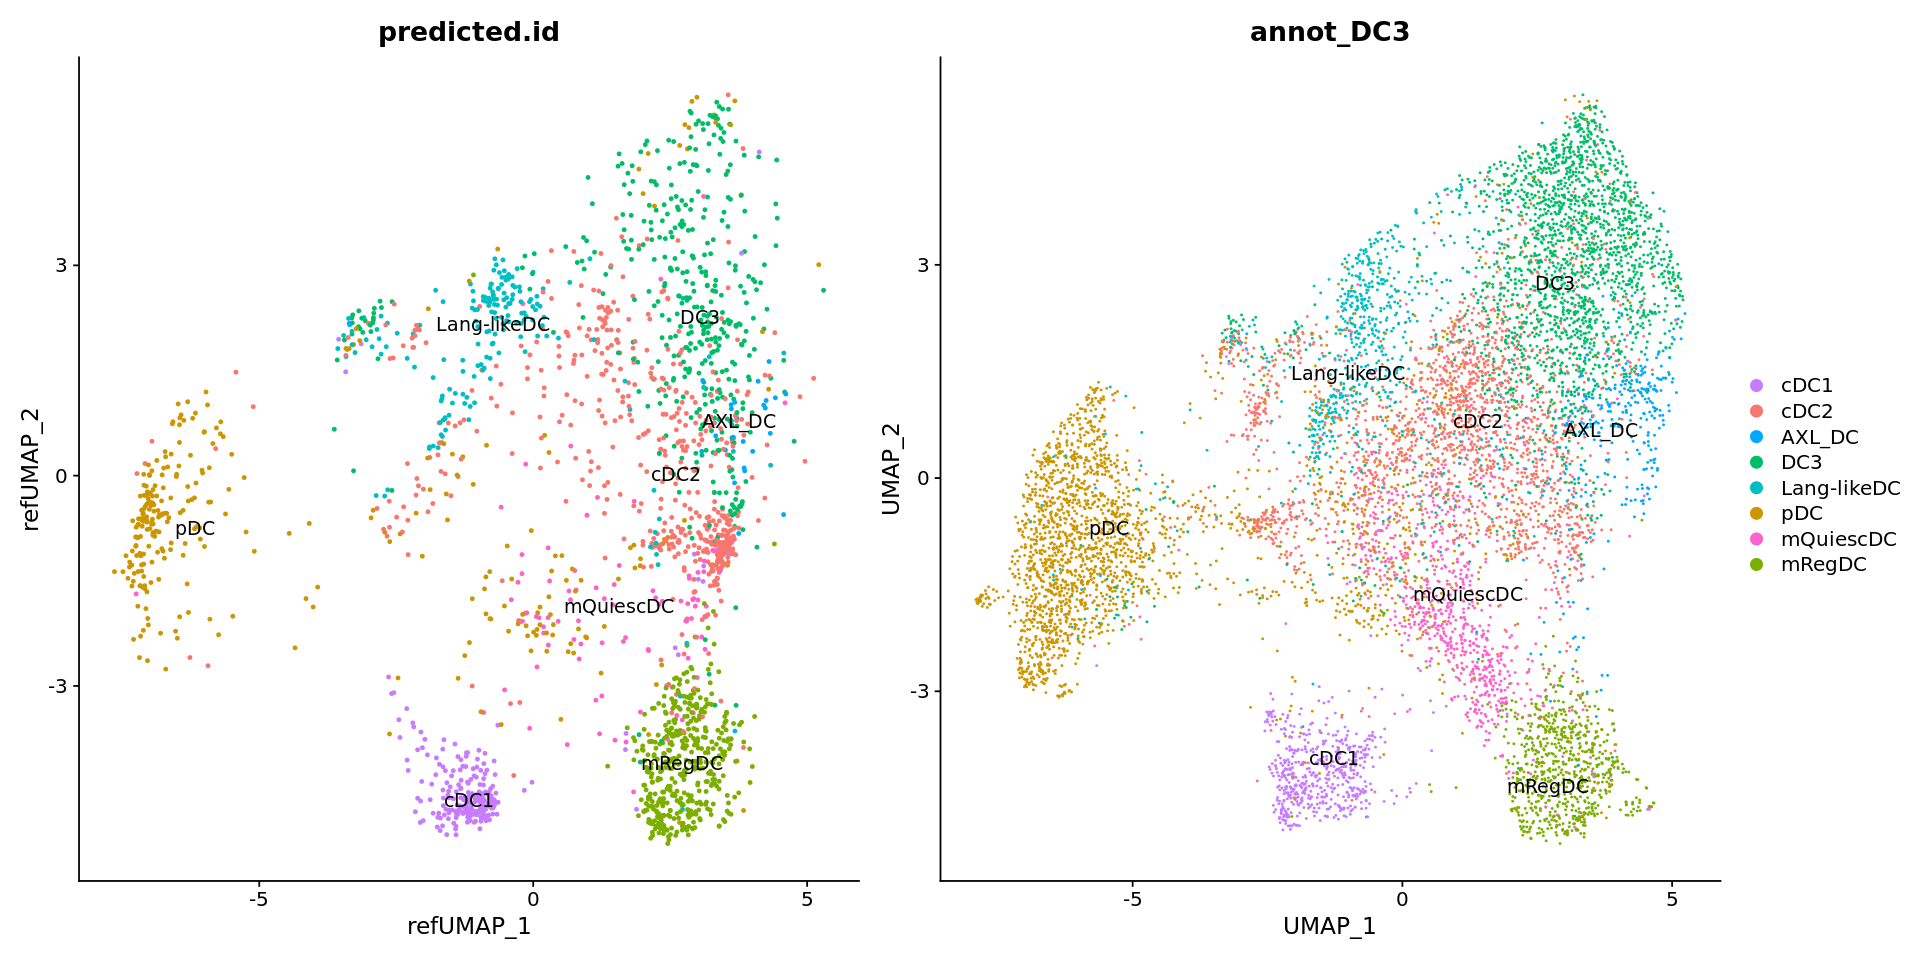

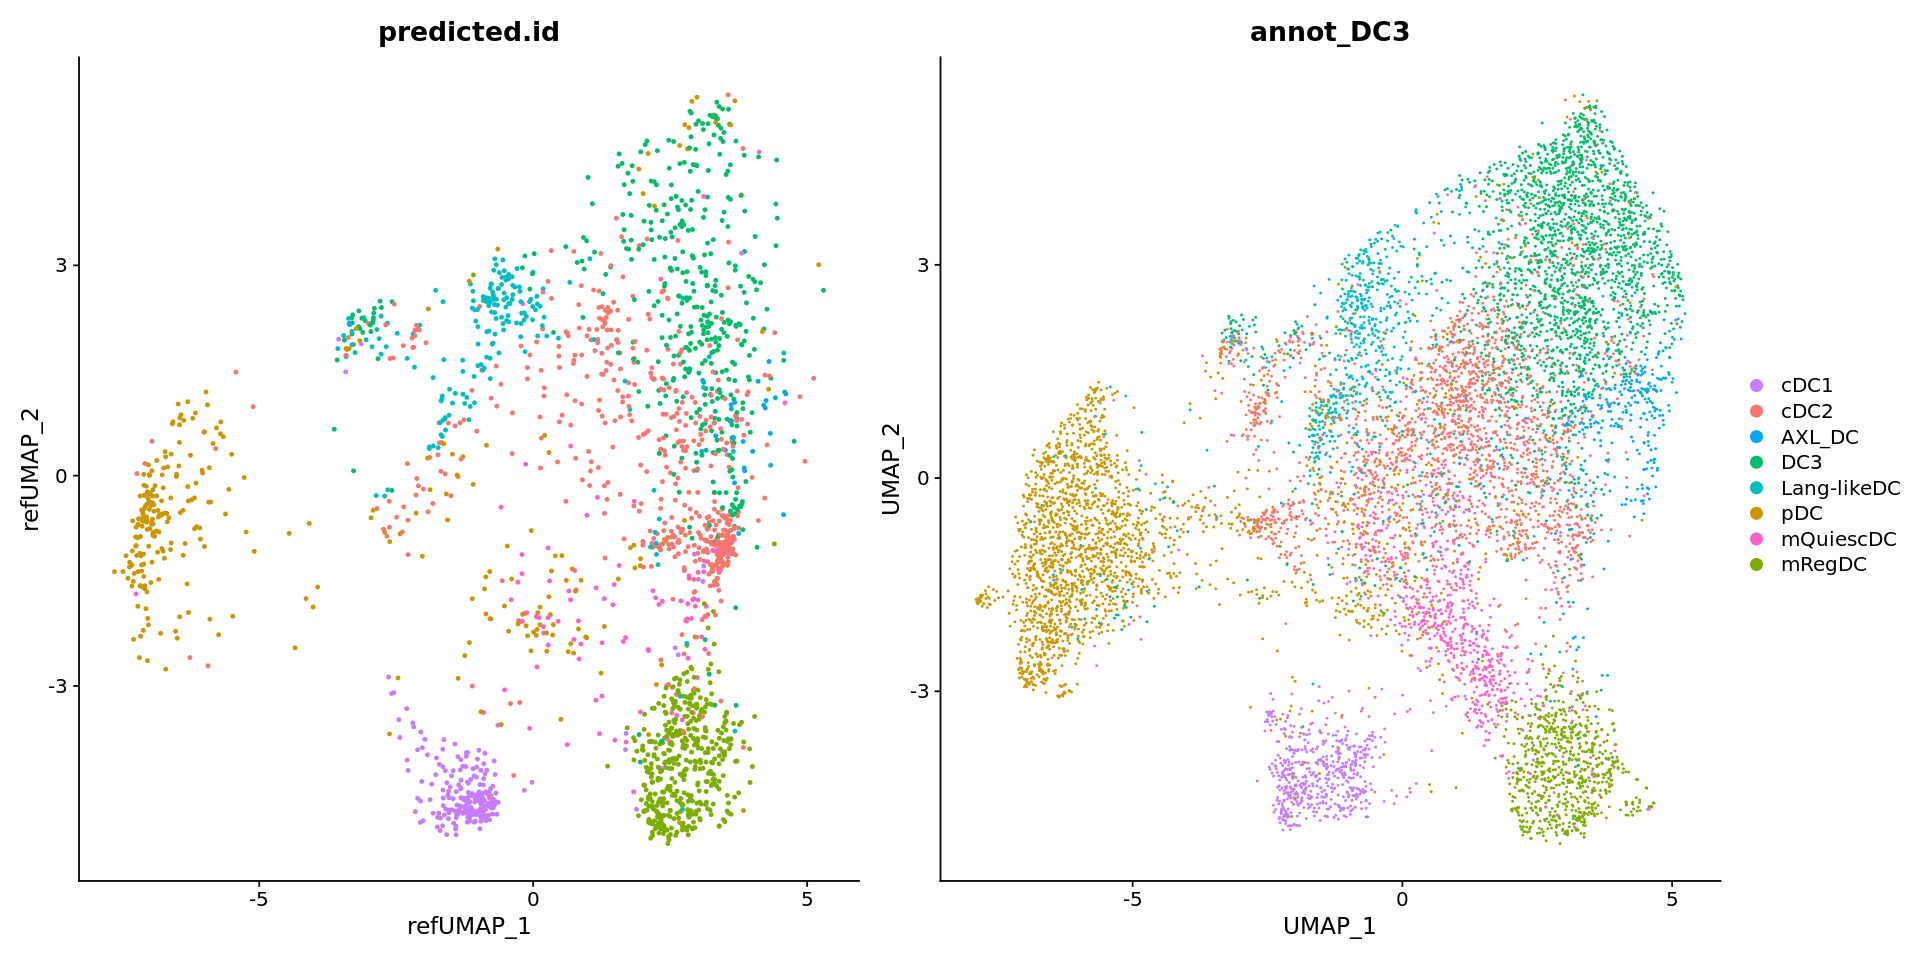

In [17]:
dd.col <- hue_pal()(length(unique(pancancer_sc$annot_DC3)))
names(dd.col) <- unique(pancancer_sc$annot_DC3)

figsize(16, 8)
(DimPlot(obj.query, reduction = "ref.umap", group.by="predicted.id", label=TRUE) + NoLegend()) + 
    DimPlot(obj.ref, reduction = "umap", group.by="annot_DC3", label=TRUE, repel = TRUE) & 
    scale_color_manual(values = dd.col) 

(DimPlot(obj.query, reduction = "ref.umap", group.by="predicted.id") + NoLegend()) + 
    DimPlot(obj.ref, reduction = "umap", group.by="annot_DC3") & 
    scale_color_manual(values = dd.col)

In [18]:
saveRDS(obj.query, file.path(dir, "DC_query.rds"))
saveRDS(obj.ref, file.path(dir, "DC_ref.rds"))

## Validate annotation - heatmap

In [4]:
obj.query <- readRDS(file.path(dir, "DC_query.rds"))
obj.ref <- readRDS(file.path(dir, "DC_ref.rds"))

In [37]:
Idents(obj) <- obj$`Xenium_snn_res.0.8`
markers <- FindAllMarkers(obj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.5)
write.csv(markers, file = paste0(dir, "/Heesoo_results/FindAllMarkers_DC.csv"), row.names = FALSE)

Calculating cluster 0



Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5



In [18]:
source("/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/Figure_functions.R")

DC_gene_list <- list(`cDC1` = c("CLEC9A", "XCR1", "BATF3"),
                    `cDC2` = c("CLEC10A", "FCGR2B", "ITGAM", "CD1C"),
                    `AXL DC` = c("AXL", "TLR3", "CST7", "MMP1", "MMP9", "MMP12", "MMP14", "CD276", "ENTPD1"),
                    `DC3` = c("C1QA", "C1QB", "CD163", "VCAN", "LYZ", "ANXA1"),
                    `Lang-like DC` = c("CD207", "CD1A"),
                    `pDC` = c("LILRA4", "GZMB", "CXCR3"),
                    `Mig DC` = c("CCL17", "CCR7", "CCL19"))

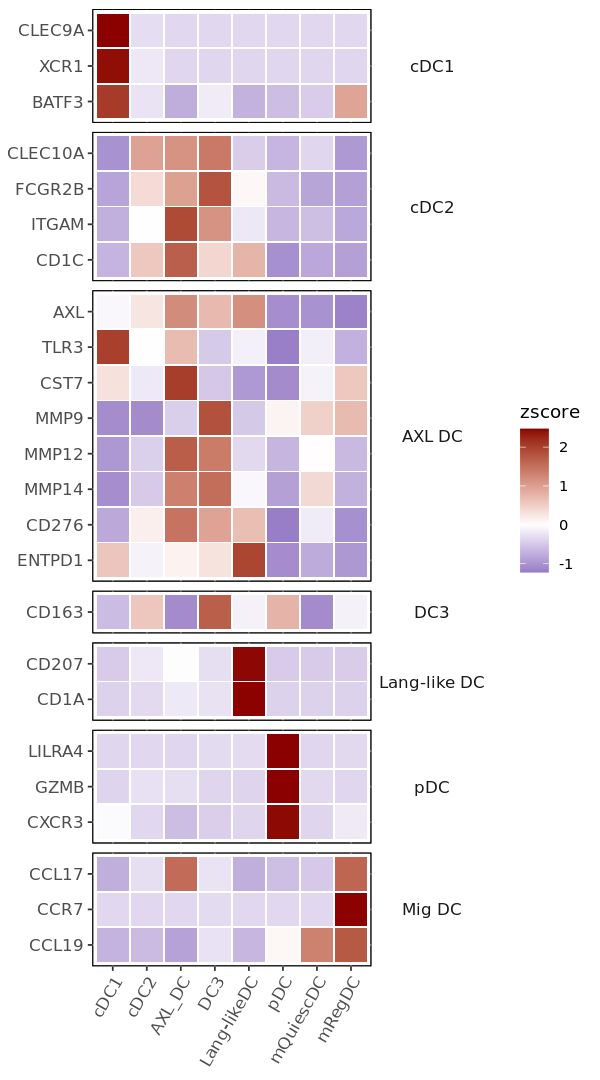

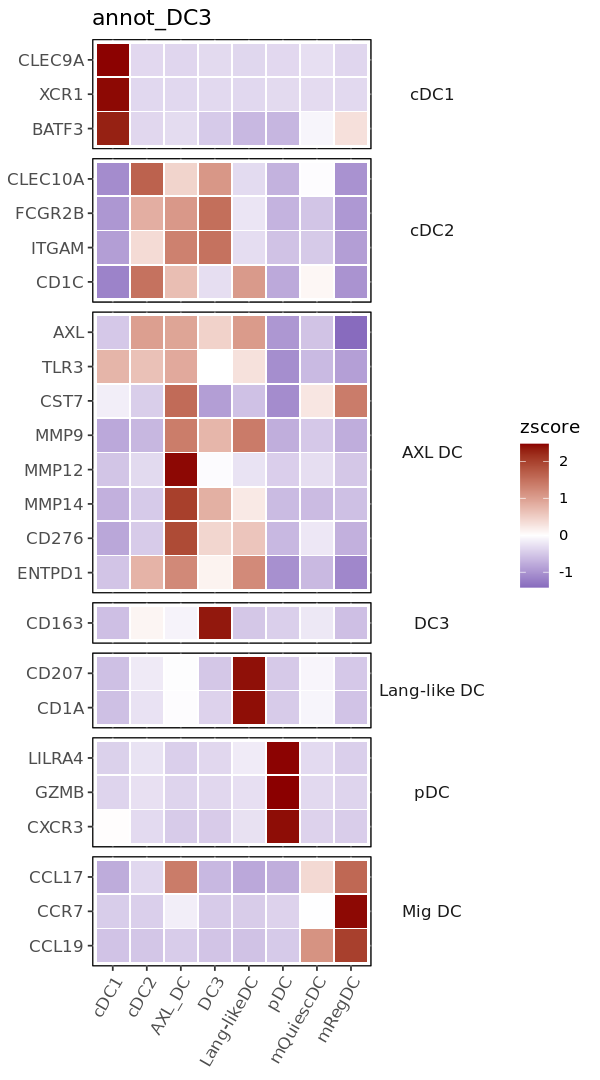

In [20]:
figsize(5, 9)
# obj.query$cluster_rename <- paste0("cluster_", obj.query$`Xenium_snn_res.0.8`)
# heatmap(obj.query, genes = DC_gene_list, assay = "Xenium", group.by = "cluster_rename")
obj.query$predicted.id <- factor(obj.query$predicted.id, levels = levels(pancancer_sc$annot_DC3))
heatmap(obj.query, genes = DC_gene_list, assay = "Xenium", group.by = "predicted.id") 
heatmap(pancancer_sc, genes = DC_gene_list, assay = "RNA", group.by = "annot_DC3") + ggtitle("annot_DC3")